In [ ]:
#Exhaust example

Starting in Design Manager mode
Playing macro: /u/cd9zen/models/starPy/exhaust/ExportProjectToJSON.java
Design Set "All" is exported to /u/cd9zen/models/starPy/exhaust/._ds_exp/exhaust_Single Opt - Min 1 Const_AllDesigns.csv
Design Set "All" is exported to /u/cd9zen/models/starPy/exhaust/._ds_exp/exhaust_Pareto Opt - Min 1 Const_AllDesigns.csv
Design Set "All" is exported to /u/cd9zen/models/starPy/exhaust/._ds_exp/exhaust_Multi Opt - Min 1 Const_AllDesigns.csv
Design Set "All" is exported to /u/cd9zen/models/starPy/exhaust/._ds_exp/exhaust_Multi Opt - Min 2 Const_AllDesigns.csv
Design Set "All" is exported to /u/cd9zen/models/starPy/exhaust/._ds_exp/exhaust_Pareto Opt - Min 2 Const_AllDesigns.csv
Design Set "All" is exported to /u/cd9zen/models/starPy/exhaust/._ds_exp/exhaust_Multi Opt - Mid 2 Const_AllDesigns.csv
Design Set "All" is exported to /u/cd9zen/models/starPy/exhaust/._ds_exp/exhaust_Multi Opt - Max 2 Const_AllDesigns.csv
Design Set "All" is exported to /u/cd9zen/models/star

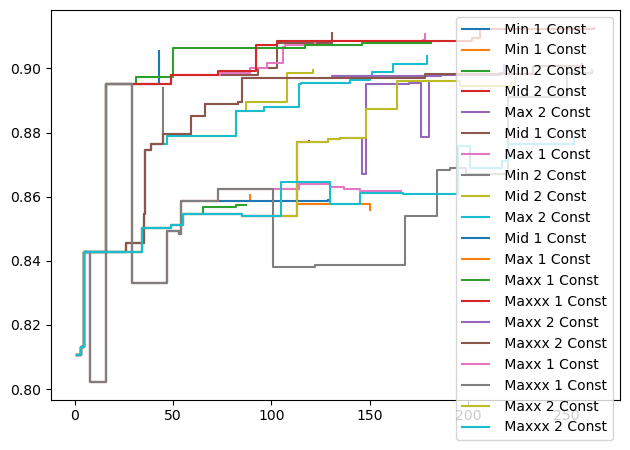

IndexError: index -1 is out of bounds for axis 0 with size 0

In [2]:
import common.star_api.design_manager as dm
import common.visualization as viz
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path

work_dir = Path(r"/u/cd9zen/models/starPy/exhaust")
name = "exhaust"
version = "19.04.006-R8"
distrib =r"/install/STAR-CCMP/lin64-r8/19.04.006_01/STAR-CCM+19.04.006-R8/star/bin/starccm+"
port = 47827


def plot_best_design_histories(proj: dm.DesignManagerProject):
    fig, ax = plt.subplots()
    only_opt = [s for s in proj if "Pareto" not in s.name]
    for study in only_opt:
        label = study.name.split("-")[-1]
        df = study.get_all_designs().data_frame()
        ax = viz.plot_history(df=df, y_col="Uniformity - Velocity MA", best_design=False, scatter=False, ax=ax,
                              label=label)
    ax.legend(loc="best")
    plt.tight_layout()
    plt.show()
    fig.savefig(work_dir.joinpath("bestDesignHist.png"), dpi=300)


def plot_statistical_histories(proj: dm.DesignManagerProject):
    only_opt = [s for s in proj if "Pareto" not in s.name]
    max_designs = 0
    for study in only_opt:
        m = study.get_all_designs().designs[-1].get_design_number()
        if m > max_designs:
            max_designs = m

    d = {"Design#": np.arange(1, max_designs + 1)}
    for study in only_opt:
        data = study.get_design_set("All Best").generate_history(col_name="Uniformity - Velocity MA",
                                                                 max_designs=max_designs)
        d[study.name] = data[:, 1]

    data = pd.DataFrame(d)
    data2 = data[data.columns[1:]]
    data["Min"] = data2.min(axis=1)
    data["Average"] = data2.mean(axis=1)
    data["Median"] = data2.median(axis=1)
    data["Max"] = data2.max(axis=1)
    data["Q1"] = data2.quantile(0.25, axis=1)
    data["Q3"] = data2.quantile(0.75, axis=1)
    fig, ax = plt.subplots()
    x = data["Design#"].to_numpy()
    med = data["Median"].to_numpy()
    q1 = data["Q1"].to_numpy()
    q3 = data["Q3"].to_numpy()
    ax.plot(x, med, color="k", linestyle="-", linewidth=2.0)
    ax.fill_between(x, q1, q3, alpha=0.25, color="k")
    plt.tight_layout()
    plt.show()
    fig.savefig(work_dir.joinpath("statistical.png"), dpi=300)


def modify_study_parameters(study: dm.Study):
    continuous = [p for p in study.parameters if p.type == dm.Parameter.Type.CONTINUOUS]
    for param in continuous:
        if param.baseline == 0.0:
            mode = "abs"
            param.set_ranges(mode=mode, u_bnd=0.1, l_bnd=-0.1)
        else:
            param.set_ranges(u_bnd=10.0, l_bnd=-10.0, sig_fig=2)


if __name__ == "__main__":
    dmprj_path = work_dir.joinpath(f"{name}.dmprj")
    dmprj = dm.DesignManagerProject.get_live_proj(dmprj_path=dmprj_path, port=port, distrib=distrib, version=version)
    s1_study = dmprj.get_study("Single Opt - Min 1 Const")
    modify_study_parameters(s1_study)
    dmprj.sync(push_to_star=True)
    plot_best_design_histories(dmprj)
    plot_statistical_histories(dmprj)
